# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_3-jitter5:cores+wisig -> oracle.run1.framed",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": 100,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag", "jitter_256_5", "take_200"],
            "episode_transforms": [],
            "domain_prefix": "C_A_",
        },
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": 100,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag", "jitter_256_5", "take_200"],
            "episode_transforms": [],
            "domain_prefix": "W_A_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [
                "unit_mag",
                "jitter_256_5",
                "take_200",
                "resample_20Msps_to_25Msps",
            ],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
    ],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'W_A_1', 'W_A_3', 'C_A_1', 'C_A_2', 'C_A_5', 'C_A_3', 'C_A_4', 'W_A_2', 'W_A_4'}


{'ORACLE.run1_32', 'ORACLE.run1_20', 'ORACLE.run1_8', 'ORACLE.run1_50', 'ORACLE.run1_14', 'ORACLE.run1_38', 'ORACLE.run1_26', 'ORACLE.run1_44'}


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)

In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 2081], examples_per_second: 126.7391, train_label_loss: 2.7022, 


epoch: 1, [batch: 209 / 2081], examples_per_second: 3192.0900, train_label_loss: 0.1636, 


epoch: 1, [batch: 417 / 2081], examples_per_second: 3231.8829, train_label_loss: 1.2104, 


epoch: 1, [batch: 625 / 2081], examples_per_second: 3232.1679, train_label_loss: 0.1088, 


epoch: 1, [batch: 833 / 2081], examples_per_second: 3233.3379, train_label_loss: 1.0815, 


epoch: 1, [batch: 1041 / 2081], examples_per_second: 3212.2115, train_label_loss: 0.1306, 


epoch: 1, [batch: 1249 / 2081], examples_per_second: 3236.3271, train_label_loss: 0.5240, 


epoch: 1, [batch: 1457 / 2081], examples_per_second: 3198.9368, train_label_loss: 0.6131, 


epoch: 1, [batch: 1665 / 2081], examples_per_second: 3196.2203, train_label_loss: 0.1851, 


epoch: 1, [batch: 1873 / 2081], examples_per_second: 3192.8999, train_label_loss: 0.3265, 


epoch: 1, source_val_acc_label: 0.9166, target_val_acc_label: 0.1731, source_val_label_loss: 0.4662, target_val_label_loss: 2.4949, 


New best


epoch: 2, [batch: 1 / 2079], examples_per_second: 10.4583, train_label_loss: 0.1425, 


epoch: 2, [batch: 208 / 2079], examples_per_second: 3212.9950, train_label_loss: 0.3637, 


epoch: 2, [batch: 416 / 2079], examples_per_second: 3226.7658, train_label_loss: 0.0295, 


epoch: 2, [batch: 624 / 2079], examples_per_second: 3239.1381, train_label_loss: 0.2409, 


epoch: 2, [batch: 832 / 2079], examples_per_second: 3244.5121, train_label_loss: 1.0900, 


epoch: 2, [batch: 1040 / 2079], examples_per_second: 3237.2809, train_label_loss: 0.3443, 


epoch: 2, [batch: 1247 / 2079], examples_per_second: 3236.8195, train_label_loss: 0.0116, 


epoch: 2, [batch: 1455 / 2079], examples_per_second: 3215.4360, train_label_loss: 0.6586, 


epoch: 2, [batch: 1663 / 2079], examples_per_second: 3243.2524, train_label_loss: 0.1123, 


epoch: 2, [batch: 1871 / 2079], examples_per_second: 3235.8232, train_label_loss: 0.1116, 


epoch: 2, source_val_acc_label: 0.9510, target_val_acc_label: 0.2538, source_val_label_loss: 0.2309, target_val_label_loss: 2.2881, 


New best


epoch: 3, [batch: 1 / 2082], examples_per_second: 10.5080, train_label_loss: 0.3389, 


epoch: 3, [batch: 209 / 2082], examples_per_second: 3226.5383, train_label_loss: 0.7080, 


epoch: 3, [batch: 417 / 2082], examples_per_second: 3251.7826, train_label_loss: 0.4143, 


epoch: 3, [batch: 625 / 2082], examples_per_second: 3243.1089, train_label_loss: 0.4112, 


epoch: 3, [batch: 833 / 2082], examples_per_second: 3252.7297, train_label_loss: 0.3832, 


epoch: 3, [batch: 1041 / 2082], examples_per_second: 3227.3642, train_label_loss: 0.0103, 


epoch: 3, [batch: 1249 / 2082], examples_per_second: 3240.2492, train_label_loss: 0.0227, 


epoch: 3, [batch: 1457 / 2082], examples_per_second: 3205.8683, train_label_loss: 0.1463, 


epoch: 3, [batch: 1665 / 2082], examples_per_second: 3228.6753, train_label_loss: 0.1627, 


epoch: 3, [batch: 1873 / 2082], examples_per_second: 3258.9971, train_label_loss: 0.2262, 


epoch: 3, source_val_acc_label: 0.9622, target_val_acc_label: 0.2686, source_val_label_loss: 0.1703, target_val_label_loss: 2.1510, 


New best


epoch: 4, [batch: 1 / 2080], examples_per_second: 10.4847, train_label_loss: 0.2089, 


epoch: 4, [batch: 208 / 2080], examples_per_second: 3246.9593, train_label_loss: 0.4122, 


epoch: 4, [batch: 416 / 2080], examples_per_second: 3236.5073, train_label_loss: 0.0744, 


epoch: 4, [batch: 624 / 2080], examples_per_second: 3230.9749, train_label_loss: 0.0118, 


epoch: 4, [batch: 832 / 2080], examples_per_second: 3245.0229, train_label_loss: 0.1287, 


epoch: 4, [batch: 1040 / 2080], examples_per_second: 3235.9332, train_label_loss: 0.0365, 


epoch: 4, [batch: 1248 / 2080], examples_per_second: 3241.4997, train_label_loss: 0.0088, 


epoch: 4, [batch: 1456 / 2080], examples_per_second: 3202.8755, train_label_loss: 0.0370, 


epoch: 4, [batch: 1664 / 2080], examples_per_second: 3237.9963, train_label_loss: 0.0664, 


epoch: 4, [batch: 1872 / 2080], examples_per_second: 3240.7892, train_label_loss: 0.4505, 


epoch: 4, source_val_acc_label: 0.9651, target_val_acc_label: 0.2665, source_val_label_loss: 0.1614, target_val_label_loss: 2.1328, 


New best


epoch: 5, [batch: 1 / 2079], examples_per_second: 10.4867, train_label_loss: 0.0053, 


epoch: 5, [batch: 208 / 2079], examples_per_second: 3218.5439, train_label_loss: 0.0688, 


epoch: 5, [batch: 416 / 2079], examples_per_second: 3236.0324, train_label_loss: 0.0908, 


epoch: 5, [batch: 624 / 2079], examples_per_second: 3232.4885, train_label_loss: 0.0731, 


epoch: 5, [batch: 832 / 2079], examples_per_second: 3248.5339, train_label_loss: 0.0062, 


epoch: 5, [batch: 1040 / 2079], examples_per_second: 3230.5820, train_label_loss: 0.3366, 


epoch: 5, [batch: 1247 / 2079], examples_per_second: 3242.4672, train_label_loss: 0.1344, 


epoch: 5, [batch: 1455 / 2079], examples_per_second: 3211.8205, train_label_loss: 0.4998, 


epoch: 5, [batch: 1663 / 2079], examples_per_second: 3234.2495, train_label_loss: 0.1365, 


epoch: 5, [batch: 1871 / 2079], examples_per_second: 3243.1819, train_label_loss: 0.1577, 


epoch: 5, source_val_acc_label: 0.9650, target_val_acc_label: 0.2581, source_val_label_loss: 0.1553, target_val_label_loss: 2.1467, 


epoch: 6, [batch: 1 / 2081], examples_per_second: 10.5312, train_label_loss: 0.2684, 


epoch: 6, [batch: 209 / 2081], examples_per_second: 3208.0690, train_label_loss: 0.0164, 


epoch: 6, [batch: 417 / 2081], examples_per_second: 3227.3506, train_label_loss: 0.0761, 


epoch: 6, [batch: 625 / 2081], examples_per_second: 3229.2859, train_label_loss: 0.0008, 


epoch: 6, [batch: 833 / 2081], examples_per_second: 3238.5376, train_label_loss: 0.0035, 


epoch: 6, [batch: 1041 / 2081], examples_per_second: 3218.3693, train_label_loss: 0.1255, 


epoch: 6, [batch: 1249 / 2081], examples_per_second: 3228.1606, train_label_loss: 0.1280, 


epoch: 6, [batch: 1457 / 2081], examples_per_second: 3237.1069, train_label_loss: 0.0011, 


epoch: 6, [batch: 1665 / 2081], examples_per_second: 3205.9953, train_label_loss: 0.0064, 


epoch: 6, [batch: 1873 / 2081], examples_per_second: 3239.3890, train_label_loss: 0.1134, 


epoch: 6, source_val_acc_label: 0.9513, target_val_acc_label: 0.1944, source_val_label_loss: 0.2069, target_val_label_loss: 2.3610, 


epoch: 7, [batch: 1 / 2075], examples_per_second: 10.5586, train_label_loss: 0.0676, 


epoch: 7, [batch: 208 / 2075], examples_per_second: 3216.6517, train_label_loss: 0.0599, 


epoch: 7, [batch: 415 / 2075], examples_per_second: 3237.1831, train_label_loss: 0.0147, 


epoch: 7, [batch: 623 / 2075], examples_per_second: 3221.1762, train_label_loss: 0.7458, 


epoch: 7, [batch: 830 / 2075], examples_per_second: 3227.6925, train_label_loss: 0.0893, 


epoch: 7, [batch: 1038 / 2075], examples_per_second: 3227.9190, train_label_loss: 0.0186, 


epoch: 7, [batch: 1245 / 2075], examples_per_second: 3235.3944, train_label_loss: 0.0037, 


epoch: 7, [batch: 1452 / 2075], examples_per_second: 3203.7235, train_label_loss: 0.1504, 


epoch: 7, [batch: 1660 / 2075], examples_per_second: 3226.2351, train_label_loss: 0.2472, 


epoch: 7, [batch: 1867 / 2075], examples_per_second: 3244.7182, train_label_loss: 0.1587, 


epoch: 7, source_val_acc_label: 0.9680, target_val_acc_label: 0.2820, source_val_label_loss: 0.1562, target_val_label_loss: 2.0721, 


New best


epoch: 8, [batch: 1 / 2082], examples_per_second: 10.4521, train_label_loss: 0.0992, 


epoch: 8, [batch: 209 / 2082], examples_per_second: 3204.3204, train_label_loss: 0.0320, 


epoch: 8, [batch: 417 / 2082], examples_per_second: 3233.0864, train_label_loss: 0.0625, 


epoch: 8, [batch: 625 / 2082], examples_per_second: 3243.2054, train_label_loss: 0.3357, 


epoch: 8, [batch: 833 / 2082], examples_per_second: 3229.0695, train_label_loss: 0.0009, 


epoch: 8, [batch: 1041 / 2082], examples_per_second: 3215.1483, train_label_loss: 0.0016, 


epoch: 8, [batch: 1249 / 2082], examples_per_second: 3231.5501, train_label_loss: 0.0034, 


epoch: 8, [batch: 1457 / 2082], examples_per_second: 3253.3421, train_label_loss: 0.0024, 


epoch: 8, [batch: 1665 / 2082], examples_per_second: 3216.8015, train_label_loss: 0.0349, 


epoch: 8, [batch: 1873 / 2082], examples_per_second: 3247.5557, train_label_loss: 0.2708, 


epoch: 8, source_val_acc_label: 0.9661, target_val_acc_label: 0.2731, source_val_label_loss: 0.1644, target_val_label_loss: 2.0859, 


epoch: 9, [batch: 1 / 2079], examples_per_second: 10.5680, train_label_loss: 0.3226, 


epoch: 9, [batch: 208 / 2079], examples_per_second: 3194.4400, train_label_loss: 0.0153, 


epoch: 9, [batch: 416 / 2079], examples_per_second: 3226.0620, train_label_loss: 0.0013, 


epoch: 9, [batch: 624 / 2079], examples_per_second: 3218.7738, train_label_loss: 0.1075, 


epoch: 9, [batch: 832 / 2079], examples_per_second: 3229.9381, train_label_loss: 0.0485, 


epoch: 9, [batch: 1040 / 2079], examples_per_second: 3227.6580, train_label_loss: 0.0064, 


epoch: 9, [batch: 1247 / 2079], examples_per_second: 3234.5400, train_label_loss: 0.0027, 


epoch: 9, [batch: 1455 / 2079], examples_per_second: 3223.6393, train_label_loss: 0.0257, 


epoch: 9, [batch: 1663 / 2079], examples_per_second: 3201.6925, train_label_loss: 0.0501, 


epoch: 9, [batch: 1871 / 2079], examples_per_second: 3265.1946, train_label_loss: 0.1183, 


epoch: 9, source_val_acc_label: 0.9651, target_val_acc_label: 0.2579, source_val_label_loss: 0.1828, target_val_label_loss: 2.1592, 


epoch: 10, [batch: 1 / 2078], examples_per_second: 10.5507, train_label_loss: 0.0489, 


epoch: 10, [batch: 208 / 2078], examples_per_second: 3214.2158, train_label_loss: 0.0010, 


epoch: 10, [batch: 416 / 2078], examples_per_second: 3251.9978, train_label_loss: 0.0110, 


epoch: 10, [batch: 624 / 2078], examples_per_second: 3241.3124, train_label_loss: 0.0955, 


epoch: 10, [batch: 831 / 2078], examples_per_second: 3220.1774, train_label_loss: 0.1016, 


epoch: 10, [batch: 1039 / 2078], examples_per_second: 3216.5185, train_label_loss: 0.0080, 


epoch: 10, [batch: 1247 / 2078], examples_per_second: 3225.8956, train_label_loss: 0.0434, 


epoch: 10, [batch: 1454 / 2078], examples_per_second: 3229.4069, train_label_loss: 0.4030, 


epoch: 10, [batch: 1662 / 2078], examples_per_second: 3212.7615, train_label_loss: 0.0179, 


epoch: 10, [batch: 1870 / 2078], examples_per_second: 3235.6417, train_label_loss: 0.4592, 


epoch: 10, source_val_acc_label: 0.9719, target_val_acc_label: 0.2720, source_val_label_loss: 0.1431, target_val_label_loss: 2.1062, 


epoch: 11, [batch: 1 / 2075], examples_per_second: 10.4758, train_label_loss: 0.0007, 


epoch: 11, [batch: 208 / 2075], examples_per_second: 3210.3051, train_label_loss: 0.0029, 


epoch: 11, [batch: 415 / 2075], examples_per_second: 3230.7985, train_label_loss: 0.1047, 


epoch: 11, [batch: 623 / 2075], examples_per_second: 3250.3777, train_label_loss: 0.0002, 


epoch: 11, [batch: 830 / 2075], examples_per_second: 3245.2447, train_label_loss: 0.1668, 


epoch: 11, [batch: 1038 / 2075], examples_per_second: 3228.0344, train_label_loss: 0.0025, 


epoch: 11, [batch: 1245 / 2075], examples_per_second: 3228.1867, train_label_loss: 0.1064, 


epoch: 11, [batch: 1452 / 2075], examples_per_second: 3237.8862, train_label_loss: 0.1675, 


epoch: 11, [batch: 1660 / 2075], examples_per_second: 3210.4119, train_label_loss: 0.0098, 


epoch: 11, [batch: 1867 / 2075], examples_per_second: 3245.5896, train_label_loss: 0.0177, 


epoch: 11, source_val_acc_label: 0.9408, target_val_acc_label: 0.1434, source_val_label_loss: 0.2448, target_val_label_loss: 2.5776, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

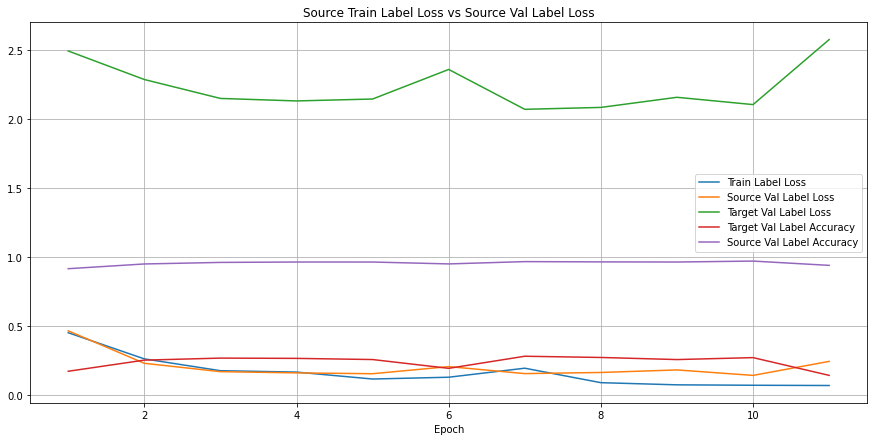

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

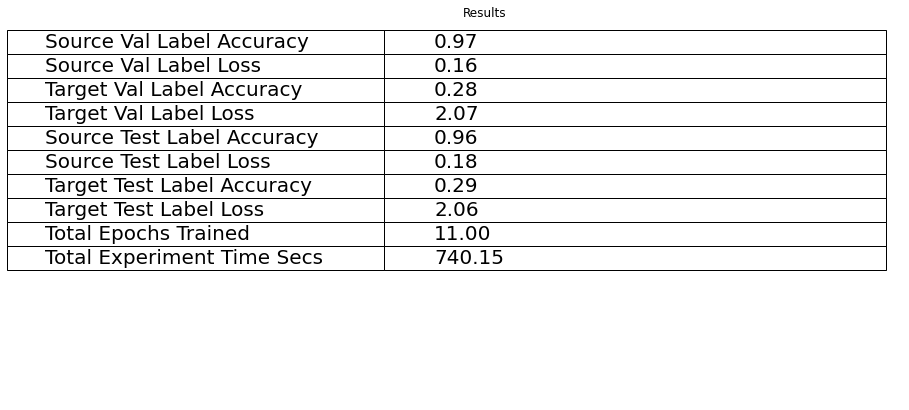

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

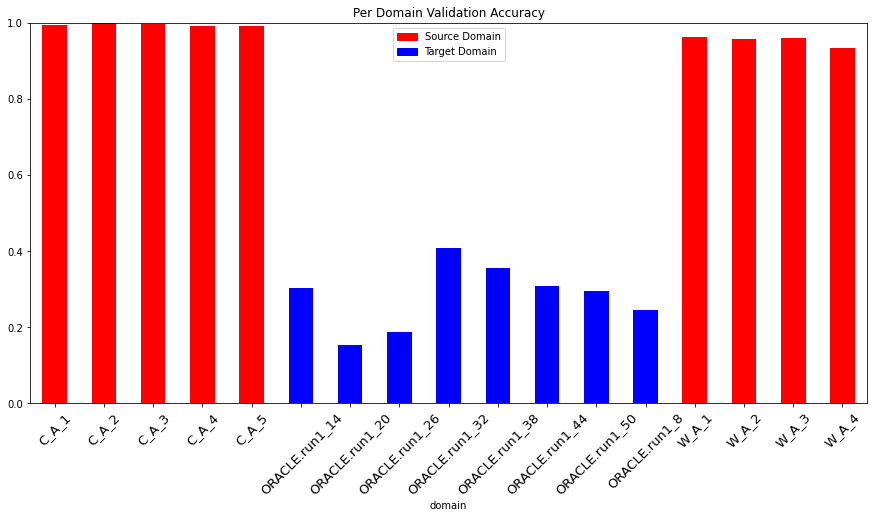

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9624357876712328 Target Test Label Accuracy: 0.2862630208333333
Source Val Label Accuracy: 0.9680008561643836 Target Val Label Accuracy: 0.28203125


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_3-jitter5:cores+wisig -> oracle.run1.framed", "parameters": {"experiment_name": "tl_3-jitter5:cores+wisig -> oracle.run1.framed", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Lin